In [24]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

plt.rcParams['figure.figsize'] = [16, 8]

In [18]:
trans = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

trainset = datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=trans)
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=4, 
    shuffle=True, 
    num_workers=3)

testset = datasets.CIFAR10(
    root='./data', 
    train=False, 
    download=True, 
    transform=trans)
testloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=4, 
    shuffle=True, 
    num_workers=3)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [19]:
def imshow(img):
    img = img / 2. + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

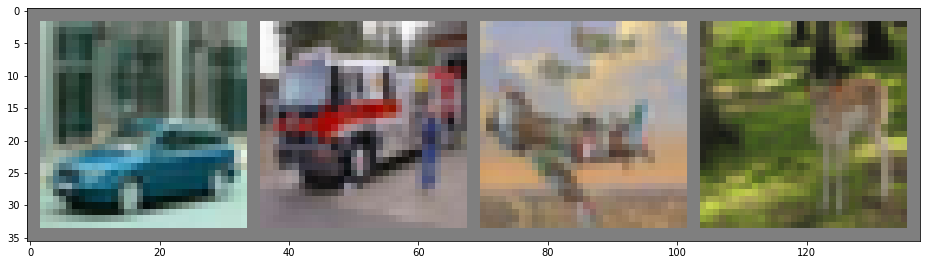

  car truck plane  deer


In [20]:
data_iter = iter(trainloader)
images, labels = data_iter.next()

imshow(utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [23]:
net = Net()

In [26]:
# cross entropy loss, stochastic gradient descent with momentum
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [29]:
for epoch in range(10):
    running_loss = 0.
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.227
[1,  4000] loss: 1.887
[1,  6000] loss: 1.674
[1,  8000] loss: 1.582
[1, 10000] loss: 1.522
[1, 12000] loss: 1.475
[2,  2000] loss: 1.393
[2,  4000] loss: 1.382
[2,  6000] loss: 1.356
[2,  8000] loss: 1.331
[2, 10000] loss: 1.318
[2, 12000] loss: 1.313
[3,  2000] loss: 1.230
[3,  4000] loss: 1.248
[3,  6000] loss: 1.227
[3,  8000] loss: 1.216
[3, 10000] loss: 1.193
[3, 12000] loss: 1.199
[4,  2000] loss: 1.118
[4,  4000] loss: 1.119
[4,  6000] loss: 1.144
[4,  8000] loss: 1.109
[4, 10000] loss: 1.135
[4, 12000] loss: 1.119
[5,  2000] loss: 1.026
[5,  4000] loss: 1.045
[5,  6000] loss: 1.044
[5,  8000] loss: 1.077
[5, 10000] loss: 1.083
[5, 12000] loss: 1.079
[6,  2000] loss: 0.993
[6,  4000] loss: 0.996
[6,  6000] loss: 1.006
[6,  8000] loss: 1.013
[6, 10000] loss: 1.012
[6, 12000] loss: 1.020
[7,  2000] loss: 0.928
[7,  4000] loss: 0.945
[7,  6000] loss: 0.936
[7,  8000] loss: 0.983
[7, 10000] loss: 0.972
[7, 12000] loss: 0.985
[8,  2000] loss: 0.866
[8,  4000] 

In [30]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

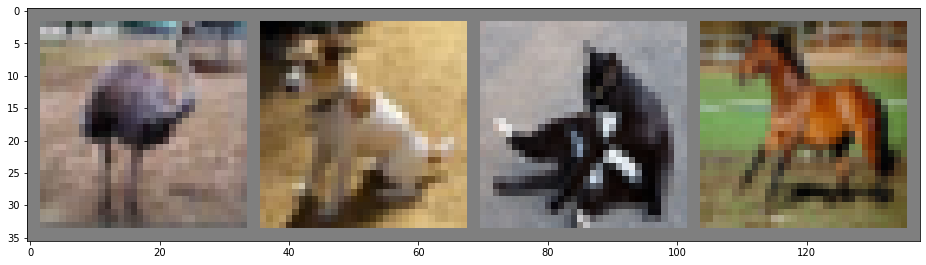

GroundTruth:   bird   dog   cat horse


In [32]:
images, labels = data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [34]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [35]:
outputs = net(images)

In [36]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   bird horse horse horse


In [37]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 72 %


In [38]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 91 %
Accuracy of  bird : 67 %
Accuracy of   cat : 50 %
Accuracy of  deer : 70 %
Accuracy of   dog : 52 %
Accuracy of  frog : 80 %
Accuracy of horse : 87 %
Accuracy of  ship : 87 %
Accuracy of truck : 69 %


In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [40]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [41]:
inputs, labels = data[0].to(device), data[1].to(device)